In [1]:
import numpy as np
from scipy.optimize import root
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import pandas as pd
import time

In [2]:
def energy_coefficients(file):
    # Read the number of parameters of this fit.
    # This determines how many columns are read and which columns correspond to each coefficient.
    num_parameters = np.genfromtxt(file, skip_header=1, max_rows=1, usecols=0, dtype=int)

    # Load the appropriate rows and columns from the data file.
    data = np.genfromtxt(file, skip_header=3, usecols=range(1, num_parameters+6))

    # Split the matter, neutron, and symmetric coefficients into their respective arrays.
    matter_coefficients = data[0]
    neutron_coefficients = data[1]
    symmetric_coefficients = data[2]

    return matter_coefficients, neutron_coefficients, symmetric_coefficients

In [3]:
def energy_term(baryon_density, coefficients):
    # Determine the number of coefficients
    # The files contain 5 extra terms that are not coefficients for the fit
    num_parameters = len(coefficients) - 5
    
    if num_parameters == 4:
        return coefficients[1]*baryon_density + coefficients[2]*baryon_density**coefficients[0] \
                + coefficients[3]*baryon_density**(2/3) + coefficients[4]*baryon_density**(5/3)

    elif num_parameters == 5:
        return coefficients[1]*baryon_density + coefficients[2]*baryon_density**coefficients[0] \
                + coefficients[3]*baryon_density**(2/3) + coefficients[4]*baryon_density**(5/3) \
                + coefficients[5]*baryon_density**3

In [4]:
def energy_term_derivative(baryon_density, coefficients):
    # Determine the number of coefficients
    # The files contain 5 extra terms that are not coefficients for the fit
    num_parameters = len(coefficients) - 5
    
    if num_parameters == 4:
        return coefficients[1] + coefficients[0]*coefficients[2]*baryon_density**(coefficients[0] - 1) \
                + (2/3)*coefficients[3]*baryon_density**(-1/3) + (5/3)*coefficients[4]*baryon_density**(2/3)

    elif num_parameters == 5:
        return coefficients[1] + coefficients[0]*coefficients[2]*baryon_density**(coefficients[0] - 1) \
                + (2/3)*coefficients[3]*baryon_density**(-1/3) + (5/3)*coefficients[4]*baryon_density**(2/3) \
                + 3*coefficients[5]*baryon_density**2

In [5]:
def find_proton_fraction(baryon_density, E_sym, x0=.1, hbar=6.582119569e-22, c=2.998e23, pi=3.14159):
    # Solve X in hbar*c(3*pi**2*X*n)**(1/3) = 4*(1-2X)*E_sym
    # Consolidate constants
    a = hbar*c*(3*pi**2*baryon_density)**(1/3)/(4*E_sym)
    
    # Find the root where x = X**(1/3)
    f = lambda x: 2*x**3 + a*x - 1
    
    # Return the value of X (which is x**3)
    # Inital guess for root is x0
    X = root(f, np.full_like(baryon_density, x0)).x**3
    
    # Return the same type as the baryon density input.
    # If it is an array, return the array of roots.
    # Otherwise return the root as a float
    if type(baryon_density) == np.ndarray:
        return X
    else:
        return X[0]

In [6]:
def find_proton_fraction2(baryon_density, E_sym, x0=.1, hbar=1.055e-27, pi=3.14159, m_e=9.109e-28):
    
    # Convert units to cgs
    # Convert baryond density from fm**-3 to cm**-3
    baryon_density *= 1e39
    # Convert E_sym from Mev to ergs
    E_sym *= 1.602e-6
    
    # Solve X in hbar/2m(3*pi**2*X*n)**(2/3) = 4*(1-2X)*E_sym
    # Consolidate constants to solve 2X + bX**(2/3) - 1 = 0
    a = hbar**2/(8*m_e*E_sym)*(3*pi**2*baryon_density)**(2/3)
    
    # Find the root where x = X**(1/3)
    f = lambda x: 2*x**3 + a*x**2 - 1
    
    # Return the value of X (which is x**3)
    # Inital guess for root is x0
    X = root(f, np.full_like(baryon_density, x0)).x**3
    
    # Return the same type as the baryon density input.
    # If it is an array, return the array of roots.
    # Otherwise return the root as a float
    if type(baryon_density) == np.ndarray:
        return X
    else:
        return X[0]

[0.05342203]


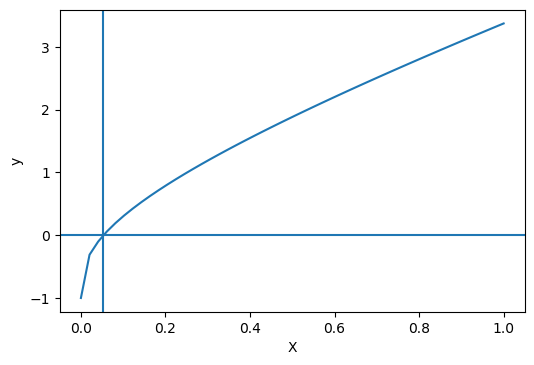

In [12]:
baryon_density = .16

# Energy per nucleon of symmetric matter
E_matter = energy_term(baryon_density, matter_coefficients)
# Symmetry term of energy. E_neutron - E_matter
E_sym = energy_term(baryon_density, symmetric_coefficients)

x0 = .1

hbar=6.582119569e-22
c=2.998e23
pi=3.14159

a = hbar*c*(3*pi**2*baryon_density)**(1/3)/(4*E_sym)

X = np.linspace(0, 1, 50)
y = 2*X + a*X**(1/3) - 1

# Find the root where x = X**(1/3)
f = lambda x: 2*x + a*x**(1/3) - 1

# Return the value of X (which is x**3)
# Inital guess for root is x0
X_root = root(f, np.full_like(baryon_density, x0)).x

print(X_root)

fig = plt.figure()
fig.patch.set_facecolor('white')
fig.set_dpi(100)

plt.plot(X, y)
plt.axhline(y=0)
plt.axvline(x=X_root)
plt.xlabel('X')
plt.ylabel('y')
plt.show()

[0.1]


/home/jgrace/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in power


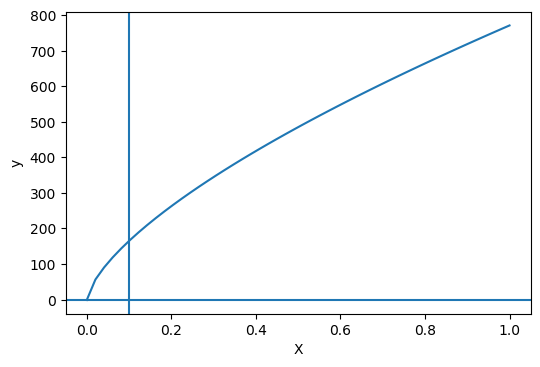

In [13]:
baryon_density = .16

# Energy per nucleon of symmetric matter
E_matter = energy_term(baryon_density, matter_coefficients)
# Symmetry term of energy. E_neutron - E_matter
E_sym = energy_term(baryon_density, symmetric_coefficients)

x0=.1

hbar=1.055e-27
pi=3.14159
m_e=9.109e-28

# Convert baryon density to 1/cm**3
baryon_density *= 1e39
# Convert energy to ergs
E_sym *= 1.602e-6

a = hbar**2/(8*m_e*E_sym)*(3*pi**2*baryon_density)**(2/3)

X = np.linspace(0, 1, 50)
y = 2*X + a*X**(2/3) - 1

# Find the root where x = X**(1/3)
f = lambda x: 2*x + a*x**(2/3) - 1

# Return the value of X (which is x**3)
# Inital guess for root is x0
X_root = root(f, np.full_like(baryon_density, x0)).x

print(X_root)

fig = plt.figure()
fig.patch.set_facecolor('white')
fig.set_dpi(100)

plt.plot(X, y)
plt.axhline(y=0)
plt.axvline(x=X_root)
plt.xlabel('X')
plt.ylabel('y')
plt.show()

3.16289e-16
6.109479635525306e-28


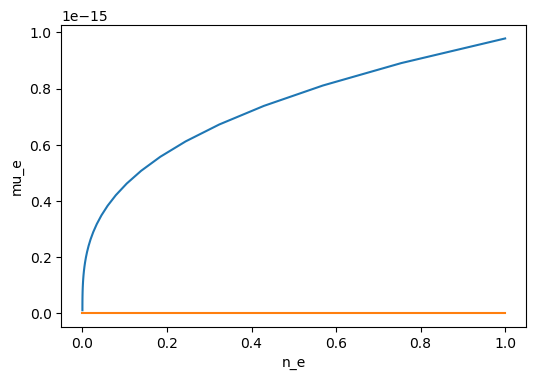

In [23]:
hbar=1.055e-27
pi=3.14159
m_e=9.109e-28
c = 2.998e11

n_e = np.logspace(-6, 0, 50)

mu_e1 = hbar*c*(3*pi**2*n_e)**(1/3)
mu_e2 = hbar**2/(2*m_e)*(3*pi**2*n_e)**(2/3)

print(hbar*c)
print(hbar**2/(2*m_e))

fig = plt.figure()
fig.patch.set_facecolor('white')
fig.set_dpi(100)

plt.plot(n_e, mu_e1, label='electron pressure')
plt.plot(n_e, mu_e2, label='degenerate electrons')
plt.xlabel('n_e')
plt.ylabel('mu_e')
plt.show()

In [8]:
def electron_chemical_potential(baryon_density, X):
    # Calculate asymmetry coefficient
    eta = 1 - 2*X

    return 4*eta*E_sym

In [9]:
def chemical_potentials(n, fit_file='Skyrme_data/s3q.data'):
    
    # Load energy coefficients from Skyrme data file
    matter_coefficients, neutron_coefficients, symmetric_coefficients = energy_coefficients(fit_file)
    
    # Energy per nucleon of symmetric matter
    E_matter = energy_term(n, matter_coefficients)
    # Symmetry term of energy. E_neutron - E_matter
    E_sym = energy_term(n, symmetric_coefficients)
    
    # Proton fraction determined from balance of chemical potentials
    X = find_proton_fraction(n, E_sym)
    
    # Calculate asymmetry coefficient
    eta = 1 - 2*X
    
    # Total energy per nucleon
    E_tot = E_matter + eta**2*E_sym
    
    # Energy derivative
    dEdn = energy_term_derivative(n, matter_coefficients) + eta**2*energy_term_derivative(n, symmetric_coefficients)
    
    # Electron chemical potential    
    mu_e = 4*eta*E_sym
    # Proton chemical potential
    mu_p = E_tot + n*dEdn - 2*eta*(1 + eta)*E_sym
    # Neutron chemical potenial
    mu_n = E_tot + n*dEdn + 2*eta*(1 - eta)*E_sym
    
    return mu_e, mu_p, mu_n

In [10]:
# Load data from dStar profile
# Use its baryon density array for analysis

dstar_file = 'profile90'

ePhi, pressure, density, zbar, abar, Xn = np.genfromtxt(dstar_file, skip_header=9, usecols=[6, 9, 10, 11, 12, 13], unpack=True)

# Nuclear saturation density in g/cm^3
rho_nuc = 2.3e14
# Atomic mass unit in g
amu = 1.6605e-24

# Convert mass density into baryon density in fm^-3
baryon_density = density/amu*10**-39

# Array of a range of baryon densities to evaluate
# Units of fm^-3
#n = np.linspace(np.min(baryon_density), np.max(baryon_density), 50)

# Create interpolation function for ePhi
#ePhi_interp = interp1d(baryon_density, ePhi)(n)

In [11]:
# Skyrme model
# Calculate electron, neutron, and proton chemical potentials and electron and nucleon pressures
# Does not account for superfluid neutrons

# File containing the Skyrme fit that will be used
skyrme_file = 'Skyrme_data/s3q.data'
# Load energy coefficients from Skyrme data file
matter_coefficients, neutron_coefficients, symmetric_coefficients = energy_coefficients(skyrme_file)

baryon_density = np.linspace(.01, .2, 50)

# Energy per nucleon of symmetric matter
E_matter = energy_term(baryon_density, matter_coefficients)
# Symmetry term of energy. E_neutron - E_matter
E_sym = energy_term(baryon_density, symmetric_coefficients)

# Proton fraction determined from balance of chemical potentials
X = find_proton_fraction(baryon_density, E_sym)

# Proton fraction determined from balance of chemical potentials
X2 = find_proton_fraction2(baryon_density, E_sym)

# Calculate asymmetry coefficient
eta = 1 - 2*X

# Total energy per nucleon
E_tot = E_matter + eta**2*E_sym

# Energy derivative
E_matter_derivative = energy_term_derivative(baryon_density, matter_coefficients)
E_sym_derivative = energy_term_derivative(baryon_density, symmetric_coefficients)
dEdn = E_matter_derivative + eta**2*E_sym_derivative

# Electron chemical potential    
mu_e = 4*eta*E_sym
# Proton chemical potential
mu_p = E_tot + baryon_density*dEdn - 2*eta*(1 + eta)*E_sym
# Neutron chemical potenial
mu_n = E_tot + baryon_density*dEdn + 2*eta*(1 - eta)*E_sym

# Electron pressure
P_e = .25*X*baryon_density*mu_e
# Nucleon pressure
P_n = baryon_density**2*energy_term_derivative(baryon_density, symmetric_coefficients)
# Total pressure
P = P_e + P_n

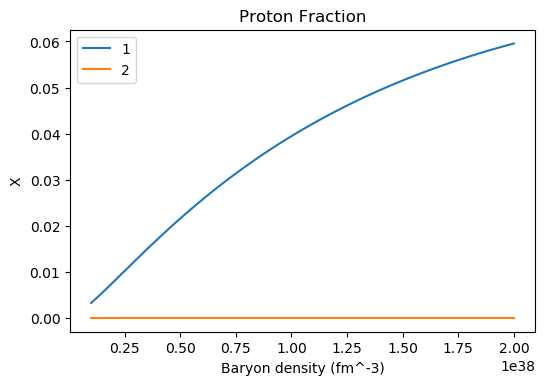

In [19]:
fig = plt.figure()
fig.patch.set_facecolor('white')
fig.set_dpi(100)

plt.plot(baryon_density, X, label='1')
plt.plot(baryon_density, X2, label='2')
plt.xlabel('Baryon density (fm^-3)')
plt.ylabel('X')
plt.title('Proton Fraction')
plt.legend()
plt.show()

1.021608250157509


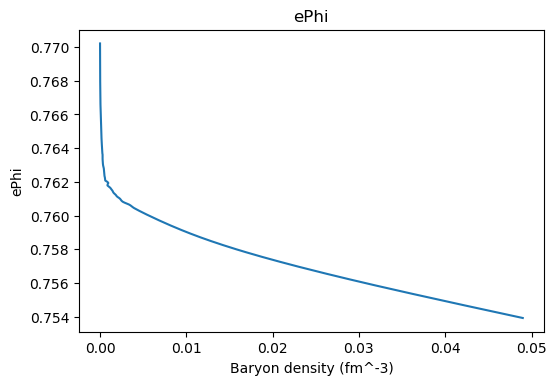

In [10]:
# Plot ePhi over range of baryon densities in dstar profile

# Total fractional change in ePhi over profile
print(ePhi[0]/ePhi[-1])

fig = plt.figure()
fig.patch.set_facecolor('white')
fig.set_dpi(100)

plt.plot(baryon_density, ePhi, label='mu_n')
plt.xlabel('Baryon density (fm^-3)')
plt.ylabel('ePhi')
plt.title('ePhi')
plt.show()

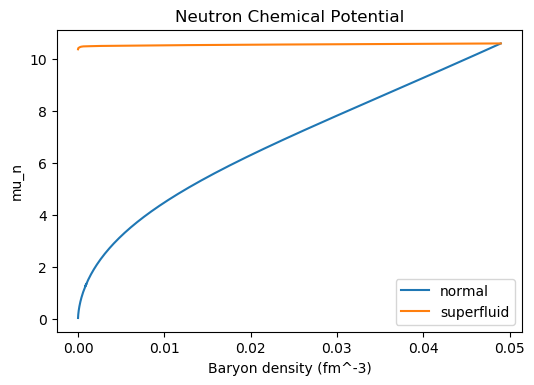

In [11]:
# Compare neutron chemical potentials for "normal" thermodynamics vs superfluid neutrons

# For superfluid neutrons, mu_n*ePhi is set at the base and is constant throughout the crust
mu_n_superfluid = mu_n[-1]*ePhi[-1]/ePhi

fig = plt.figure()
fig.patch.set_facecolor('white')
fig.set_dpi(100)

plt.plot(baryon_density, mu_n, label='normal')
plt.plot(baryon_density, mu_n_superfluid, label='superfluid')
plt.xlabel('Baryon density (fm^-3)')
plt.ylabel('mu_n')
plt.title('Neutron Chemical Potential')
plt.legend()
plt.savefig('neutron_chemical_potential')
plt.show()

/home/jgrace/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys
/home/jgrace/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  
/home/jgrace/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()
/home/jgrace/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less_equal
  # This is added back by InteractiveShellApp.init_path()
/home/jgrace/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater_equal
  if sys.path[0] == '':
/home/jgrace/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':


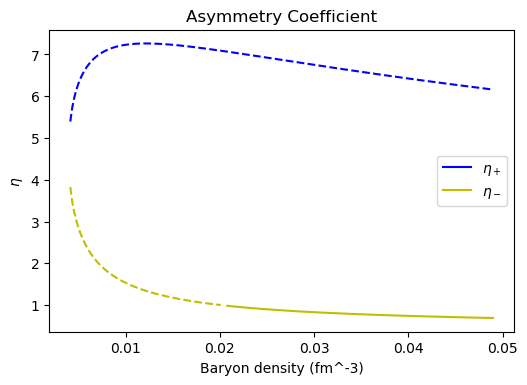

In [25]:
# Solve for asymmetry coefficient given neutron chemical potential

# Root term in the quadratic
quad_root = E_sym**2 + (E_sym - baryon_density*E_sym_derivative)*(E_matter + baryon_density*E_matter - mu_n_superfluid)

# Two solution for eta in quadratic equation
eta_plus = (E_sym + quad_root**.5)/(E_sym - baryon_density*E_sym_derivative)
eta_minus = (E_sym - quad_root**.5)/(E_sym - baryon_density*E_sym_derivative)

# Mask of valid values. Eta must be between -1 and 1
valid_eta_plus = (eta_plus >= -1.)*(eta_plus <= 1.)
valid_eta_minus = (eta_minus >= -1.)*(eta_minus <= 1.)

# Plot values of eta.
# Dashed lines indicate invalid values.
# Solid lines indicate valid values.
fig = plt.figure()
fig.patch.set_facecolor('white')
fig.set_dpi(100)

plt.plot(baryon_density[valid_eta_plus], eta_plus[valid_eta_plus], 'b-', label=r'$\eta_+$')
plt.plot(baryon_density[~valid_eta_plus], eta_plus[~valid_eta_plus], 'b--')
plt.plot(baryon_density[valid_eta_minus], eta_minus[valid_eta_minus], 'y-', label=r'$\eta_-$')
plt.plot(baryon_density[~valid_eta_minus], eta_minus[~valid_eta_minus], 'y--')
plt.xlabel('Baryon density (fm^-3)')
plt.ylabel(r'$\eta$')
plt.title('Asymmetry Coefficient')
plt.legend()
plt.savefig('asymmetry_coefficient')
plt.show()

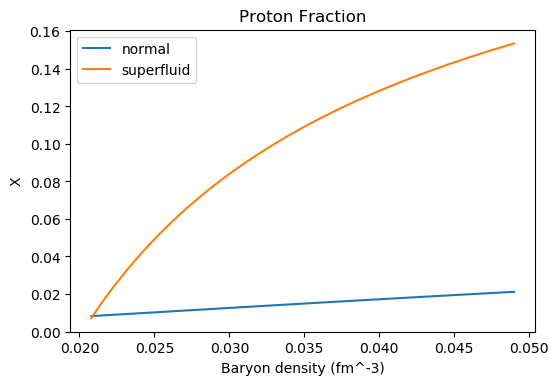

In [13]:
# Plot proton fraction based on values of eta within valid baryon density range.

# Proton fractions on valid values of eta
proton_fraction_superfluid = (1 - eta_minus[valid_eta_minus])/2
baryon_density2 = baryon_density[valid_eta_minus]

proton_fraction_normal = X[valid_eta_minus]

fig = plt.figure()
fig.patch.set_facecolor('white')
fig.set_dpi(100)

plt.plot(baryon_density2, proton_fraction_normal, label='normal')
plt.plot(baryon_density2, proton_fraction_superfluid, label='superfluid')
plt.xlabel('Baryon density (fm^-3)')
plt.ylabel('X')
plt.title('Proton Fraction')
plt.legend()
plt.show()

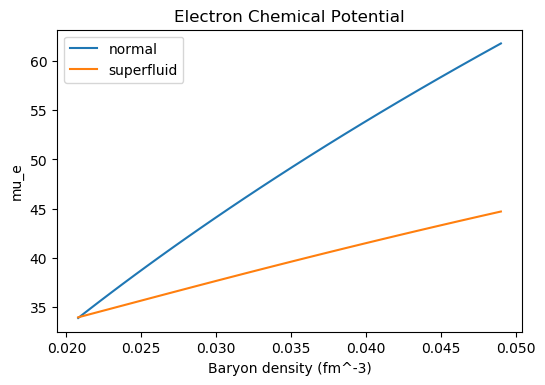

In [14]:
mu_e_superfluid = 4*eta_minus[valid_eta_minus]*E_sym[valid_eta_minus]

fig = plt.figure()
fig.patch.set_facecolor('white')
fig.set_dpi(100)

plt.plot(baryon_density2, mu_e[valid_eta_minus], label='normal')
plt.plot(baryon_density2, mu_e_superfluid, label='superfluid')
plt.xlabel('Baryon density (fm^-3)')
plt.ylabel('mu_e')
plt.title('Electron Chemical Potential')
plt.legend()
plt.show()

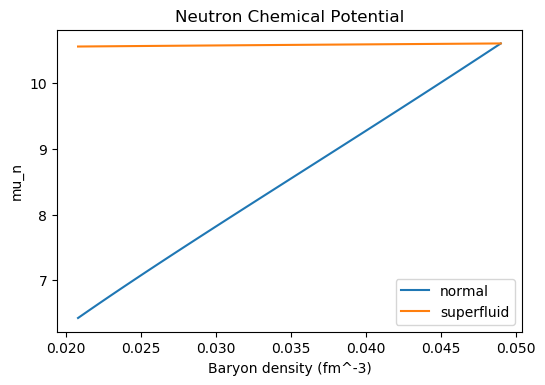

In [15]:
fig = plt.figure()
fig.patch.set_facecolor('white')
fig.set_dpi(100)

plt.plot(baryon_density2, mu_n[valid_eta_minus], label='normal')
plt.plot(baryon_density2, mu_n_superfluid[valid_eta_minus], label='superfluid')
plt.xlabel('Baryon density (fm^-3)')
plt.ylabel('mu_n')
plt.title('Neutron Chemical Potential')
plt.legend()
#plt.savefig('neutron_chemical_potential')
plt.show()

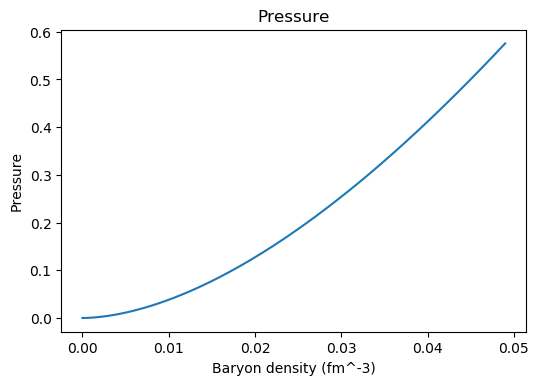

In [17]:
fig = plt.figure()
fig.patch.set_facecolor('white')
fig.set_dpi(100)

plt.plot(baryon_density, P)
plt.xlabel('Baryon density (fm^-3)')
plt.ylabel('Pressure')
plt.title('Pressure')
plt.savefig('pressure.png')
plt.show()

In [18]:
# Load array of nuclide names
nuclide_db = np.loadtxt('nuclib_db', usecols=0, dtype=str)[::4]
# Load nuclide library data
nuclib_db = np.loadtxt('nuclib_db', usecols=range(1, 6))[::4]

mass_number = nuclib_db[:,0].astype(int)
charge_number = nuclib_db[:,1].astype(int)
neutron_number = nuclib_db[:,2].astype(int)
#ground_state_spin = nuclib_db[:,3]

mass_excess = np.full((int(np.max(charge_number)) + 1, int(np.max(neutron_number)) + 1), np.NaN)

for i, Z in enumerate(charge_number):
    N = neutron_number[i]
    
    mass_excess[Z, N] = nuclib_db[i, 4]

def stability(Z, N, mu_n, mu_e):
    
    nuclide_mass_excess = mass_excess[Z, N]
    neutron_mass_excess = mass_excess[0, 1]
    
    try:
        neutron_separation = mass_excess[Z, N-1] + neutron_mass_excess - nuclide_mass_excess + mu_n > 0
    except IndexError:
        neutron_separation = True
    try:
        neutron_capture = nuclide_mass_excess + neutron_mass_excess - mass_excess[Z, N+1] + mu_n > 0
    except IndexError:
        neutron_capture = True
    try:
        electron_emission = mass_excess[Z+1, N-1] - nuclide_mass_excess + mu_e > 0
    except IndexError:
        electron_emission = True
    try:
        electron_capture = mass_excess[Z-1, N+1] - nuclide_mass_excess - mu_e > 0
    except IndexError:
        electron_capture = True
    
    return neutron_separation and neutron_capture and electron_emission and electron_capture

In [19]:
# Grid of nuclides on which to check stability.
# Index nuclides such that nuclide_grid[Z, A] corresponds to the stability of nuclide with charge number Z and neutron number N
# Values of -1, 0, 1 correspond to no data, unstable, stable respectively.

# Initialize grid with all values of -1 (no data)
nuclide_grid = np.full((int(np.max(charge_number)) + 1, int(np.max(neutron_number)) + 1), -1)

# Iterate through nuclides in database to mark all included nuclides as unstable.
for i, Z  in enumerate(charge_number):
    N = neutron_number[i]
    
    nuclide_grid[int(Z), int(N)] = 0

In [21]:
n = baryon_density[-1]

mu_e, mu_p, mu_n = chemical_potentials(n)

start = time.time()

for Z in range(nuclide_grid.shape[0]):
    for N in range(nuclide_grid.shape[1]):
        nuclide_grid[Z, N] = stability(Z, N, mu_n, mu_e)
    
end = time.time()
print(end-start)

0.0679619312286377


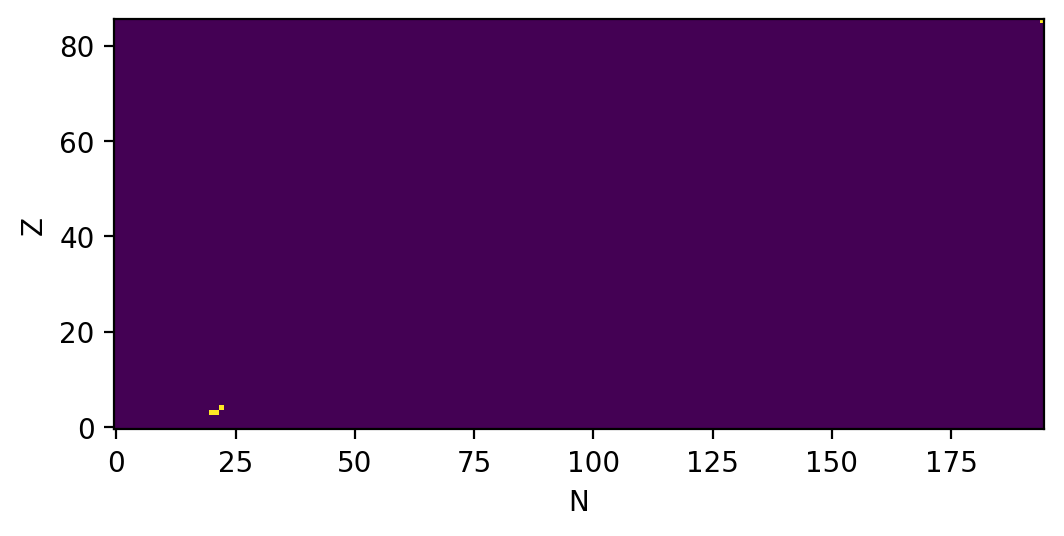

In [22]:
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')
fig.set_dpi(200)

im = ax.imshow(nuclide_grid, origin='lower')
#ax.set_xticks(np.arange(0, np.shape(nuclide_grid)[1], 10))
#ax.set_yticks(np.arange(0, np.shape(nuclide_grid)[0], 10))
plt.xlabel('N')
plt.ylabel('Z')
plt.show()